# Marble 1: Quick Diagnostic

**Did it work?**

Fast plots from metrics.csv to see if the model learned anything interesting.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tokenizers import Tokenizer

plt.rcParams['figure.dpi'] = 200
STEELBLUE = '#4682B4'

In [4]:
PROJECT_ROOT = Path.cwd().parent.parent.parent.parent
METRICS_PATH = PROJECT_ROOT / 'box_4' / 'tensors' / 'Marble-1' / 'metrics.csv'
TOKENIZER_PATH = PROJECT_ROOT / 'box_4' / 'data' / 'flannel_tokenizer_chars.json'

df = pd.read_csv(METRICS_PATH)
tokenizer = Tokenizer.from_file(str(TOKENIZER_PATH))

print(f"Loaded {len(df)} steps")
print(f"Columns: {list(df.columns)}")

Loaded 5000 steps
Columns: ['step', 'epoch', 'loss', 'top1', 'top2', 'top3', 'h_autocorr', 'dead_moving']


## 1. Loss Curve

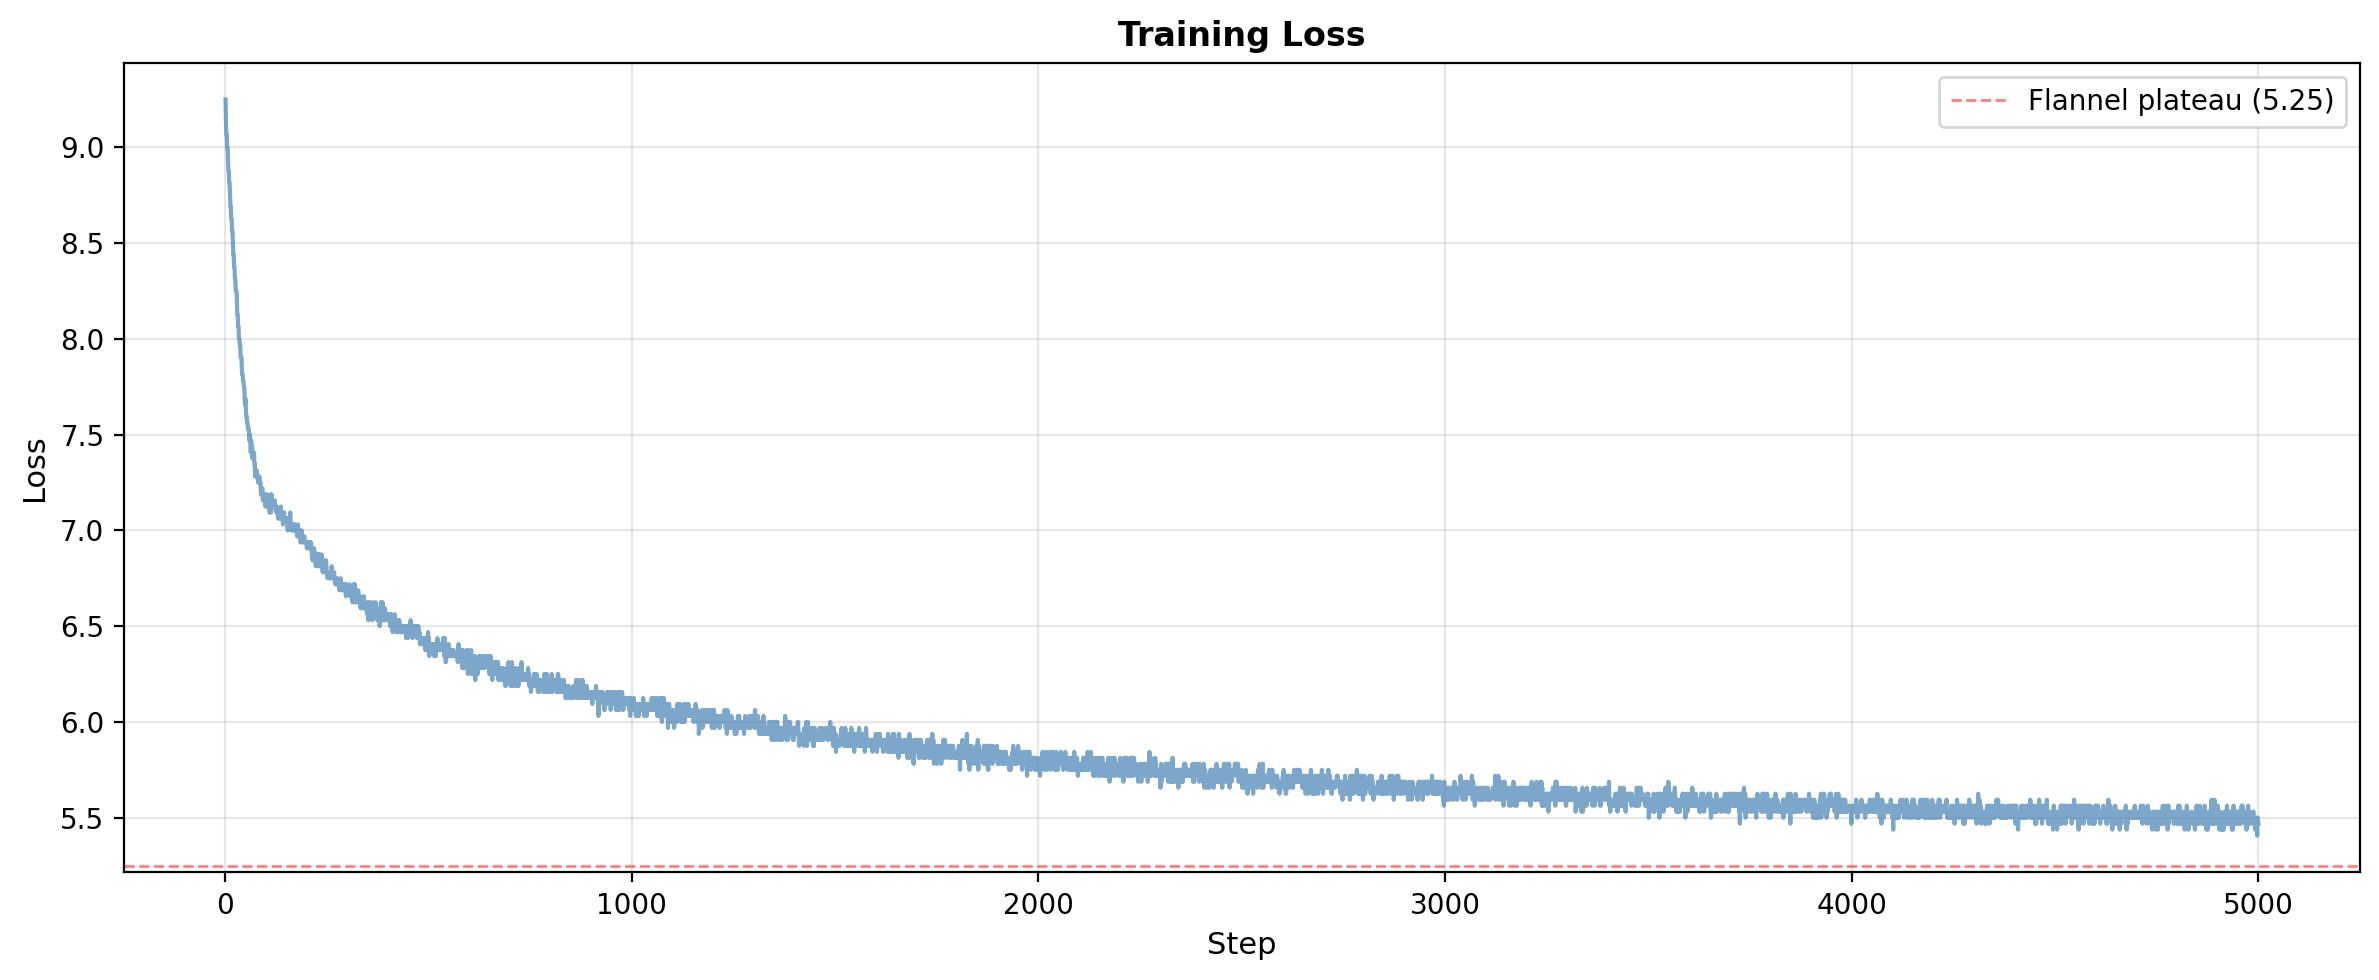

Final loss: 5.4688
Min loss: 5.4062
✗ Still stuck in unigram hell


In [5]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df['step'], df['loss'], color=STEELBLUE, linewidth=1.5, alpha=0.7)
ax.axhline(y=5.25, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Flannel plateau (5.25)')

ax.set_xlabel('Step', fontsize=11)
ax.set_ylabel('Loss', fontsize=11)
ax.set_title('Training Loss', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final loss: {df['loss'].iloc[-1]:.4f}")
print(f"Min loss: {df['loss'].min():.4f}")

if df['loss'].iloc[-1] < 5.0:
    print("✓ Better than Flannel!")
else:
    print("✗ Still stuck in unigram hell")

## 2. h_mean Autocorrelation

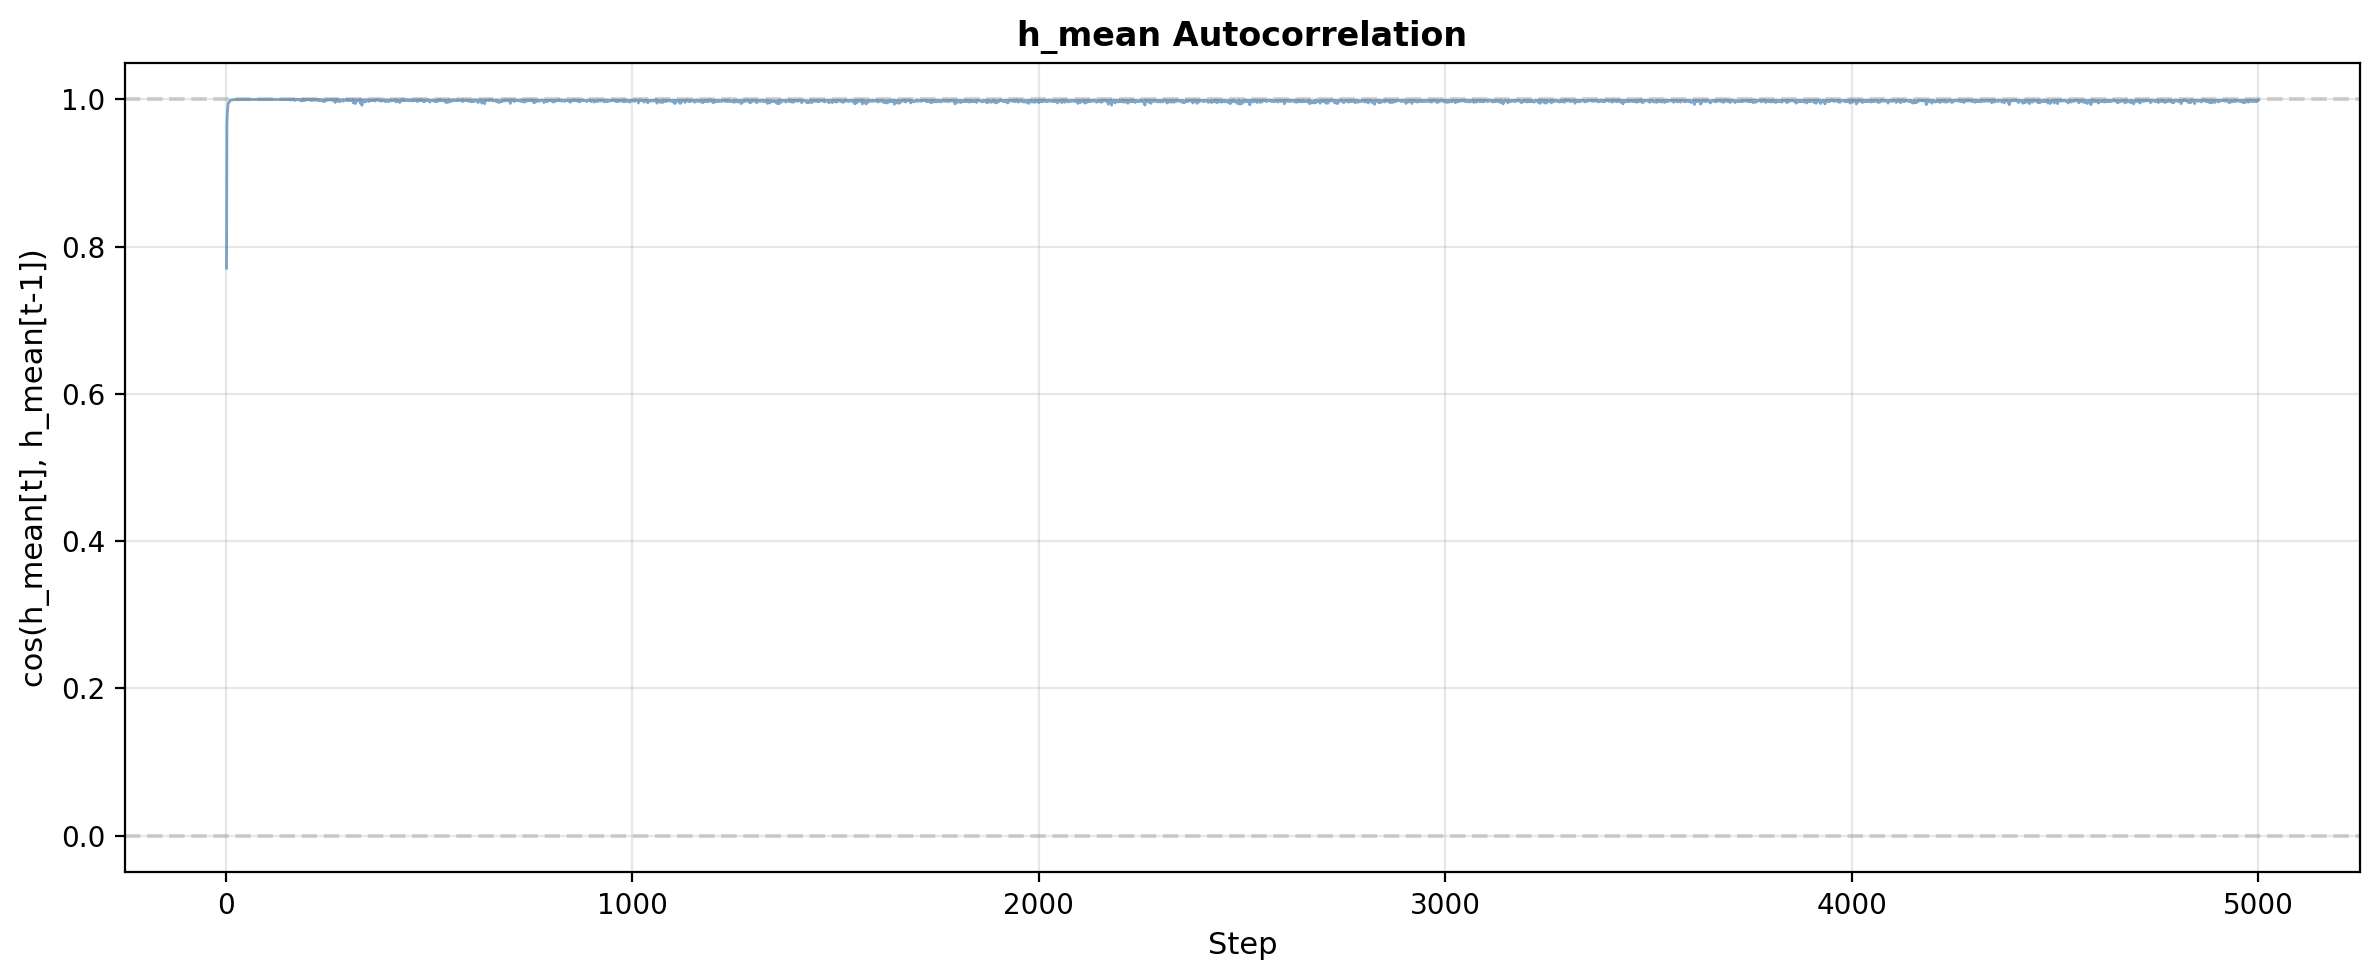

Mean autocorr: 0.9981
Min autocorr: 0.7708
✗ h_mean stayed in narrow cone (never explored much)


In [6]:
fig, ax = plt.subplots(figsize=(12, 5))

# Skip first value (NaN)
valid = df['h_autocorr'].notna()
ax.plot(df.loc[valid, 'step'], df.loc[valid, 'h_autocorr'], 
        color=STEELBLUE, linewidth=1, alpha=0.7)

ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.3)
ax.axhline(y=0.0, color='gray', linestyle='--', alpha=0.3)

ax.set_xlabel('Step', fontsize=11)
ax.set_ylabel('cos(h_mean[t], h_mean[t-1])', fontsize=11)
ax.set_title('h_mean Autocorrelation', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

autocorr_mean = df['h_autocorr'].mean()
autocorr_min = df['h_autocorr'].min()

print(f"Mean autocorr: {autocorr_mean:.4f}")
print(f"Min autocorr: {autocorr_min:.4f}")

if autocorr_min < 0:
    print("✓ h_mean explored >90° (cos < 0)")
elif autocorr_min < 0.5:
    print("✓ h_mean explored >60° (cos < 0.5)")
else:
    print("✗ h_mean stayed in narrow cone (never explored much)")

## 3. Dead Token Motion

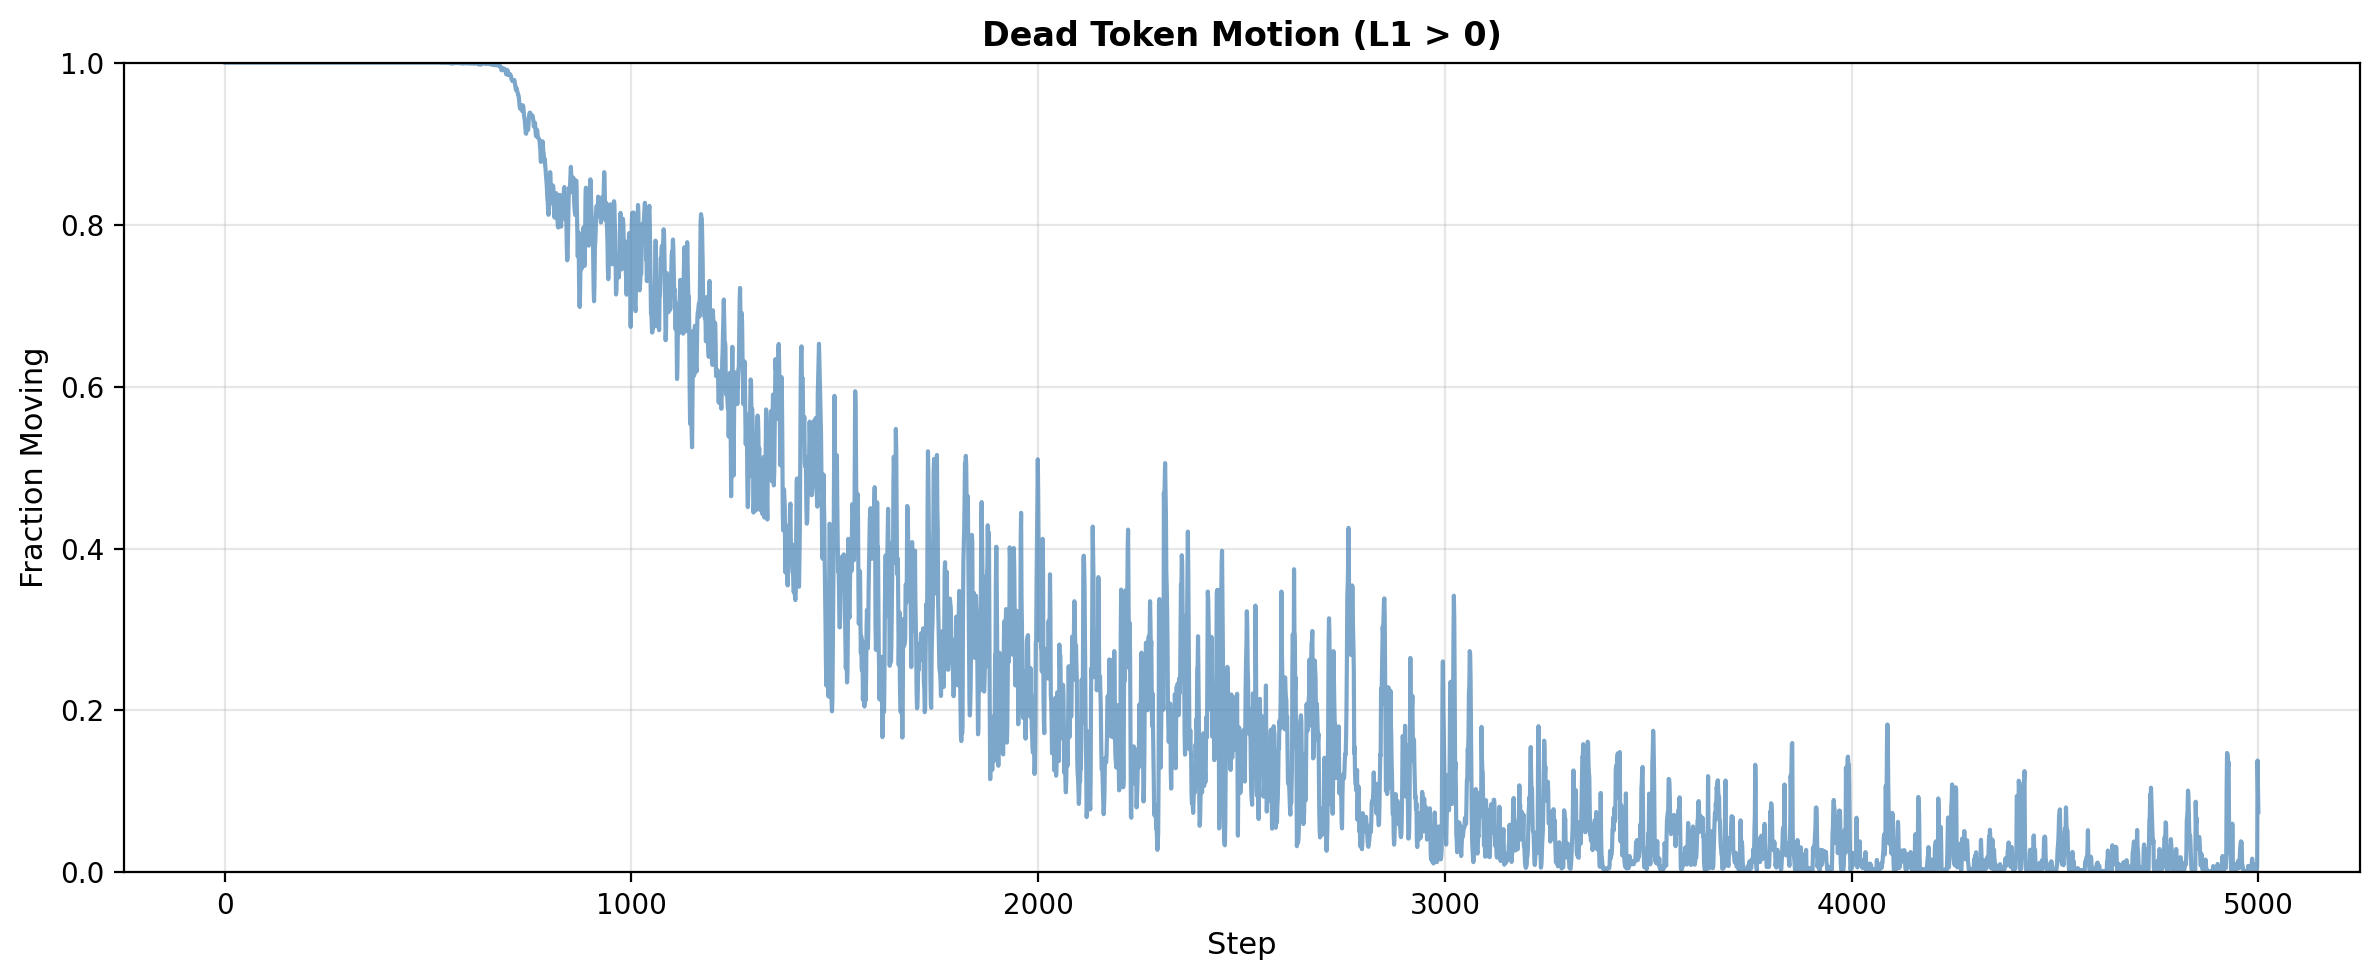

Early (first 100): 1.000
Late (last 100): 0.019
✓ Dead tokens slowing down (approaching freeze)


In [7]:
fig, ax = plt.subplots(figsize=(12, 5))

valid = df['dead_moving'].notna()
ax.plot(df.loc[valid, 'step'], df.loc[valid, 'dead_moving'], 
        color=STEELBLUE, linewidth=1.5, alpha=0.7)

ax.set_xlabel('Step', fontsize=11)
ax.set_ylabel('Fraction Moving', fontsize=11)
ax.set_title('Dead Token Motion (L1 > 0)', fontsize=12, fontweight='bold')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

early_motion = df.loc[valid, 'dead_moving'].iloc[:100].mean()
late_motion = df.loc[valid, 'dead_moving'].iloc[-100:].mean()

print(f"Early (first 100): {early_motion:.3f}")
print(f"Late (last 100): {late_motion:.3f}")

if late_motion < early_motion * 0.5:
    print("✓ Dead tokens slowing down (approaching freeze)")
else:
    print("✗ Dead tokens still moving (not freezing yet)")

## 4. Top Predicted Tokens Over Time

In [8]:
# Sample every 100 steps
sample_steps = [1, 100, 500, 1000, 2500, 5000]

print("Top-3 predicted tokens at key steps:")
print("=" * 60)

for step in sample_steps:
    row = df[df['step'] == step]
    if len(row) == 0:
        continue
    
    row = row.iloc[0]
    tokens = [int(row['top1']), int(row['top2']), int(row['top3'])]
    decoded = [tokenizer.decode([t]) for t in tokens]
    
    print(f"\nStep {step}:")
    for rank, (tid, tok) in enumerate(zip(tokens, decoded), 1):
        print(f"  {rank}. Token {tid:5d}: {repr(tok):20s}")

print("\n" + "=" * 60)

# Check if top tokens change
first_top = int(df.iloc[0]['top1'])
last_top = int(df.iloc[-1]['top1'])

if first_top == last_top:
    print(f"\n✗ Top token never changed (always token {first_top})")
else:
    print(f"\n✓ Top token changed (from {first_top} to {last_top})")

Top-3 predicted tokens at key steps:

Step 1:
  1. Token   537: 'च'                 
  2. Token  4622: 'เบ'                
  3. Token  8431: 'introduced'        

Step 100:
  1. Token    16: '.'                 
  2. Token  2806: 'the'               
  3. Token    14: ','                 

Step 500:
  1. Token    16: '.'                 
  2. Token    14: ','                 
  3. Token  2818: 'and'               

Step 1000:
  1. Token    16: '.'                 
  2. Token    14: ','                 
  3. Token  2818: 'and'               

Step 2500:
  1. Token    14: ','                 
  2. Token    16: '.'                 
  3. Token  2818: 'and'               

Step 5000:
  1. Token    14: ','                 
  2. Token    16: '.'                 
  3. Token  2818: 'and'               


✓ Top token changed (from 537 to 14)


## Verdict

In [9]:
print("=" * 70)
print("MARBLE 1 VERDICT")
print("=" * 70)

final_loss = df['loss'].iloc[-1]
min_autocorr = df['h_autocorr'].min()
late_motion = df.loc[df['dead_moving'].notna(), 'dead_moving'].iloc[-100:].mean()

score = 0

print("\nCriteria:")

if final_loss < 5.0:
    print(f"  ✓ Loss < 5.0: {final_loss:.4f}")
    score += 1
else:
    print(f"  ✗ Loss ≥ 5.0: {final_loss:.4f}")

if min_autocorr < 0.5:
    print(f"  ✓ h_mean explored >60°: min cos = {min_autocorr:.4f}")
    score += 1
else:
    print(f"  ✗ h_mean stayed narrow: min cos = {min_autocorr:.4f}")

if first_top != last_top:
    print(f"  ✓ Top token changed over training")
    score += 1
else:
    print(f"  ✗ Top token never changed")

if late_motion < 0.5:
    print(f"  ✓ Dead tokens slowing: {late_motion:.3f} moving")
    score += 1
else:
    print(f"  ✗ Dead tokens still active: {late_motion:.3f} moving")

print(f"\nScore: {score}/4")

if score >= 3:
    print("\n🎉 SUCCESS: Model is worth studying!")
    print("   → Build deep-dive analysis notebooks")
    print("   → Use as E. coli for Qwen dynamics")
elif score >= 2:
    print("\n🤔 MIXED: Some promise, needs tuning")
    print("   → Try Marble 2 with adjusted hyperparams")
else:
    print("\n❌ FAILURE: Back to the drawing board")
    print("   → Try bigger model or different architecture")

print("\n" + "=" * 70)

MARBLE 1 VERDICT

Criteria:
  ✗ Loss ≥ 5.0: 5.4688
  ✗ h_mean stayed narrow: min cos = 0.7708
  ✓ Top token changed over training
  ✓ Dead tokens slowing: 0.019 moving

Score: 2/4

🤔 MIXED: Some promise, needs tuning
   → Try Marble 2 with adjusted hyperparams

